In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris, load_breast_cancer,make_classification,make_moons
from sklearn.metrics import classification_report
import numpy as np;
import matplotlib.pyplot as plt;

In [3]:
class LogisticTreeClassifier(BaseEstimator, ClassifierMixin): 
    """An example of classifier"""
 
    def __init__(self):
        """
        Called when initializing the classifier
        """
        pass;
 
    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X) == y))
    
    def __corr(self,mat, y):
        s1=((mat - mat.mean(axis=0))/mat.std(axis=0));
        s2=((y-y.mean())/y.std()).reshape(-1,1);
        
        return np.mean(s1*s2,axis=0)
       
   
    def fitLevel(self,X,y, level=0, tab=''):
        if y.sum() == 0 or y.sum() == len(y):
            return {'type':'constant', 'value':y.mean()}
        
        
        correlation = np.abs(self.__corr(X,y));

        mostCorrelated = np.argsort(correlation)[-1];
        clf = LogisticRegression();

        Xcut = X[:,mostCorrelated].reshape(-1,1);
        out = clf.fit(Xcut,y).predict(Xcut);
        #print(tab+"%d==> X=%.0f | mostCorrelated= %d,score=%0.2f |  0=%0.0f 1=%0.0f "
        #      %(level,len(X),mostCorrelated, clf.score(Xcut,y),(out==0).sum(), out.sum()))
        
        splitSize = out.sum();
      
        if splitSize > 0 and splitSize < len(X):
            r = {
                'type': 'partial',
                'index':mostCorrelated,
                'clf':clf,
                'level0':self.fitLevel(X[out==False],y[out==False],level=level+1,tab=tab+'\t'),
                'level1':self.fitLevel(X[out==True],y[out==True],level=level+1,tab=tab+'\t')
            }
        else:
            r = {
                'type': 'complete',
                'index':mostCorrelated,
                'clf':clf,
            }
        return r;


    def fit(self, X, y=None):
        """
        """
        self.classes_ = np.unique(y);
        self.classifierTree_ = self.fitLevel(X,y);       
        return self 

    
    def predLevel(self,X, level):
        #print("type "+level['type'])
        if level['type'] == 'constant':
            return np.ones(len(X)) * level['value'];
        
        p = level['clf'].predict(X[:,level['index']].reshape(-1,1));
        
        if level['type'] == 'complete':
            return p;

        if level['type'] == 'partial':
            result = np.zeros(len(X))
            if (1-p).sum()>0:
                result[p==0] = self.predLevel(X[p==False],level['level0']);
            if p.sum()>0:
                result[p==1] = self.predLevel(X[p==True],level['level1'])
            
            return result;

    def predprobaLevel(self,X, level):
        #print("\n\n",level['type'])
        if level['type'] == 'constant':
            r=np.ones(len(X))*level['value'];
            r = np.vstack((1-r,r)).T
            return r;
        
        p = level['clf'].predict_proba(X[:,level['index']].reshape(-1,1));
        
        if level['type'] == 'complete':
            return p;

        if level['type'] == 'partial':
            result = np.zeros((len(X),2))
            p = (p[:,1] >0.5).flatten();
            if (1-p).sum()>0:
                result[p==0] = self.predprobaLevel(X[p==False],level['level0']);
                
            if p.sum()>0:
                result[p==1] = self.predprobaLevel(X[p==True],level['level1']);
            
            return result;
        
    def predict(self, X, y=None):
        try:
            getattr(self, "classifierTree_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return self.predLevel(X,self.classifierTree_);
    
    
    def predict_proba(self,X,y=None):
        try:
            getattr(self, "classifierTree_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return self.predprobaLevel(X,self.classifierTree_);       

In [4]:
bcancer = load_breast_cancer()

iris = load_iris()
data = iris['data']
t = iris['target']==0

data, t = make_classification(n_samples=100,n_features=100, n_redundant=0, n_informative=5, n_clusters_per_class=1);
data, t= make_moons(n_samples=100, noise=0.3, random_state=0);


In [5]:
from sklearn.decomposition import PCA;
vis = PCA().fit_transform(data)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(data,t, test_size=0.33, random_state=22)

             precision    recall  f1-score   support

        0.0       0.88      0.88      0.88        16
        1.0       0.88      0.88      0.88        17

avg / total       0.88      0.88      0.88        33



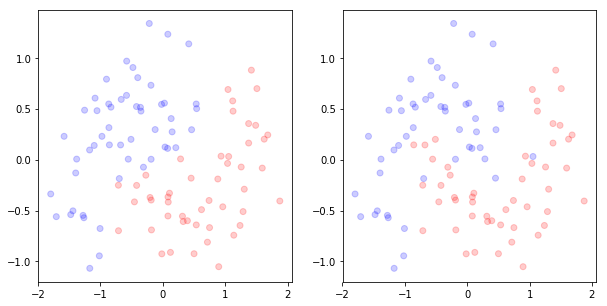

In [8]:
clf = LogisticTreeClassifier()
print(classification_report(clf.fit(xtrain,ytrain).predict(xtest),ytest))
pred = clf.predict(data)
plt.figure(figsize=(10,5))
plt.subplot(121);plt.scatter(vis[:,0],vis[:,1], alpha=0.2,c=list(map(lambda x: 'red' if x else 'blue',pred)));
plt.subplot(122);plt.scatter(vis[:,0],vis[:,1], alpha=0.2,c=list(map(lambda x: 'red' if x else 'blue',t)));

In [9]:
def printTree(t, level=''):
    for i in ('type','index'):
        if i in t:
            print("%s %s=%s" % (level,i, t[i]));
        
    
    for i in t:
        if i not in(('index','type','level0','level1', 'clf')):
            print("%s %s=%s" % (level,i, t[i]));
    
    if 'level0' in t:
        print("%s level0" %(level));
        printTree(t['level0'], level+'\t');
    
    if 'level1' in t:
        print("%s level1" %(level));
        printTree(t['level1'], level+'\t');

printTree(clf.classifierTree_);


 type=partial
 index=1
 level0
	 type=partial
	 index=0
	 level0
		 type=complete
		 index=1
	 level1
		 type=constant
		 value=1.0
 level1
	 type=partial
	 index=0
	 level0
		 type=constant
		 value=0.0
	 level1
		 type=complete
		 index=1


             precision    recall  f1-score   support

          0       0.94      0.79      0.86        19
          1       0.76      0.93      0.84        14

avg / total       0.86      0.85      0.85        33



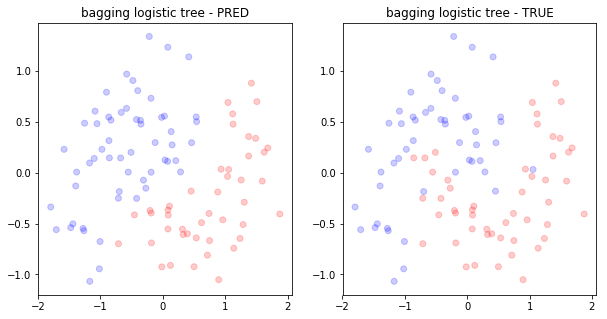

In [10]:
from sklearn.ensemble import BaggingClassifier
dtree = BaggingClassifier(LogisticTreeClassifier(),n_estimators=2)
print(classification_report(dtree.fit(xtrain,ytrain).predict(xtest),ytest))
pred = dtree.predict(data)
plt.figure(figsize=(10,5))
plt.subplot(121);plt.scatter(vis[:,0],vis[:,1], alpha=0.2,c=list(map(lambda x: 'red' if x else 'blue',pred)));plt.title("bagging logistic tree - PRED");
plt.subplot(122);plt.scatter(vis[:,0],vis[:,1], alpha=0.2,c=list(map(lambda x: 'red' if x else 'blue',t)));plt.title("bagging logistic tree - TRUE");

             precision    recall  f1-score   support

          0       0.81      0.93      0.87        14
          1       0.94      0.84      0.89        19

avg / total       0.89      0.88      0.88        33



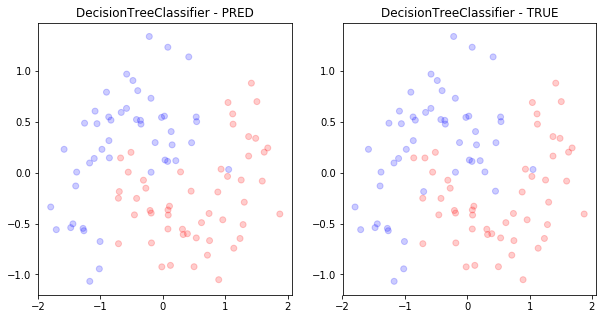

In [11]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
print(classification_report(dtree.fit(xtrain,ytrain).predict(xtest),ytest))
pred = dtree.predict(data)
plt.figure(figsize=(10,5))
plt.subplot(121);plt.scatter(vis[:,0],vis[:,1], alpha=0.2,c=list(map(lambda x: 'red' if x else 'blue',pred)));plt.title("DecisionTreeClassifier - PRED");
plt.subplot(122);plt.scatter(vis[:,0],vis[:,1], alpha=0.2,c=list(map(lambda x: 'red' if x else 'blue',t)));plt.title("DecisionTreeClassifier - TRUE");

             precision    recall  f1-score   support

          0       0.75      0.75      0.75        16
          1       0.76      0.76      0.76        17

avg / total       0.76      0.76      0.76        33



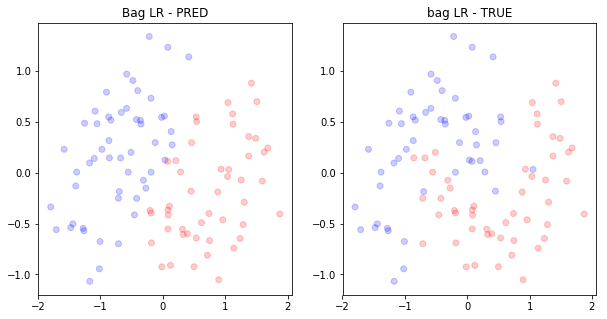

In [12]:
from sklearn.ensemble import BaggingClassifier
dtree = BaggingClassifier(LogisticRegression())
print(classification_report(dtree.fit(xtrain,ytrain).predict(xtest),ytest))
pred = dtree.predict(data)
plt.figure(figsize=(10,5))
plt.subplot(121);plt.scatter(vis[:,0],vis[:,1], alpha=0.2,c=list(map(lambda x: 'red' if x else 'blue',pred)));plt.title("Bag LR - PRED");
plt.subplot(122);plt.scatter(vis[:,0],vis[:,1], alpha=0.2,c=list(map(lambda x: 'red' if x else 'blue',t)));plt.title("bag LR - TRUE");

             precision    recall  f1-score   support

          0       0.88      0.88      0.88        16
          1       0.88      0.88      0.88        17

avg / total       0.88      0.88      0.88        33



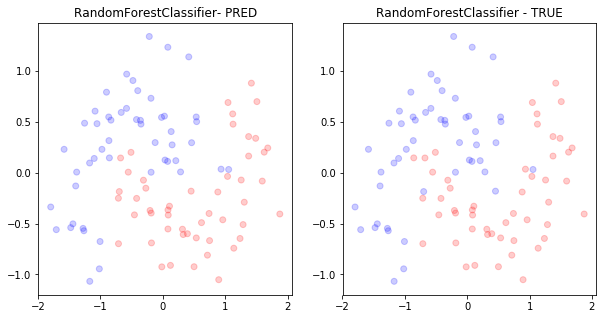

In [13]:
from sklearn.ensemble import RandomForestClassifier
dtree = RandomForestClassifier()
print(classification_report(dtree.fit(xtrain,ytrain).predict(xtest),ytest))
pred = dtree.predict(data)
plt.figure(figsize=(10,5))
plt.subplot(121);plt.scatter(vis[:,0],vis[:,1], alpha=0.2,c=list(map(lambda x: 'red' if x else 'blue',pred)));plt.title("RandomForestClassifier- PRED");
plt.subplot(122);plt.scatter(vis[:,0],vis[:,1], alpha=0.2,c=list(map(lambda x: 'red' if x else 'blue',t)));plt.title("RandomForestClassifier - TRUE");

In [14]:
np.unique(np.ones(10))

array([1.])

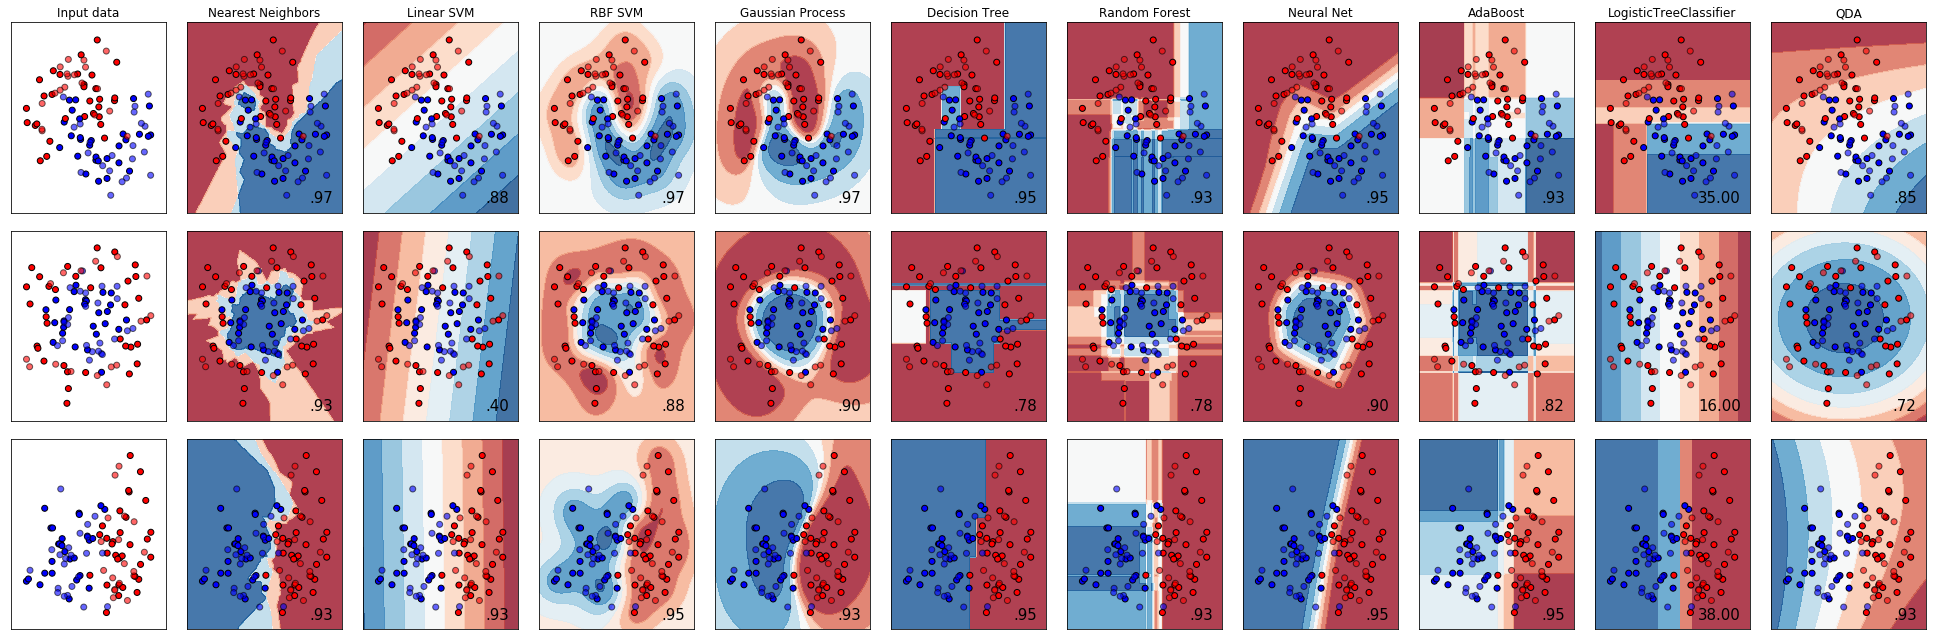

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "LogisticTreeClassifier", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1,hidden_layer_sizes=(100,100)),
    AdaBoostClassifier(),
    LogisticTreeClassifier(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()